In [3]:
import sys
import os
import warnings
from pathlib import Path
import json
import math

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv

if str(Path().resolve().parent) not in sys.path:
    sys.path.append(str(Path().resolve().parent))

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

warnings.filterwarnings("ignore", category=FutureWarning)

from src.config import PREPROCESSED_PAPER_DATASET_PATH, GENERATOR_ASSESSMENTS_PATH, GENERATOR_BEST_ASSESSMENTS_PATH
from src.text_extraction import *
from src.models_setup import embedding_model, gemini_2_flash
from src.prompts import prompt_rag, prompt_zero_cot, prompt_retry_with_memory_usage
from src.output_formats import BlogGeneration, BlogClassificationCoT
from src.helpers import get_examples, load_or_create_vector_store
from src.blog_generator import BlogGenerator
from src.long_term_memory import LongTermMemory

# Data Processing

In [4]:
# Import data
papers = pd.read_csv(PREPROCESSED_PAPER_DATASET_PATH)
papers = papers.reset_index(drop=True)

# Split dataset into validation and test set (first half for validation)
middle = papers.shape[0] // 2
Xval = papers.iloc[:middle].reset_index(drop=True)
Xtest = papers.iloc[middle:].reset_index(drop=True)

print(f"Size of validation set, X: {Xval.shape}")
print(f"Size of test set, X: {Xtest.shape}")

Size of validation set, X: (37, 4)
Size of test set, X: (37, 4)


# Generator manual test

In [3]:
vector_store = load_or_create_vector_store()

def find_most_similar_article(query_text):
    query_embedding = embedding_model.encode(query_text, clean_up_tokenization_spaces=True)
    results = vector_store.similarity_search_by_vector(query_embedding, k=2)

    if results:
        most_similar = results[1]
        return most_similar.page_content, most_similar.metadata

Vector store does not exist. Creating new one...
New vector store created successfully.


In [56]:
paper_text = Xval.loc[0, "paper_full_text"]
example_paper, example_blog_metadata = find_most_similar_article(paper_text)
example_blog = example_blog_metadata["blog_full_text"]

In [57]:
# RAG approach
llm_generator = gemini_2_flash.with_structured_output(BlogGeneration, include_raw=True)
generation_chain = prompt_rag | llm_generator
#print(prompt_rag.format(paper_text=paper_text,
#                        example_paper=example_paper,
#                        example_blog=example_blog))

In [58]:
generator_response = generation_chain.invoke({"paper_text": paper_text,
                                              "example_paper": example_paper,
                                              "example_blog": example_blog})

In [59]:
print(generator_response["parsed"].text)

# Minimum Hyperspherical Energy (MHE) in Neural Networks

## TL;DR

This blog post discusses a novel regularization technique called Minimum Hyperspherical Energy (MHE) for neural networks. MHE draws inspiration from the Thomson problem in physics to improve the generalization ability of neural networks by encouraging diversity among neurons.

## What's the Big Idea?

Neural networks are powerful, but their tendency to have redundant, highly correlated neurons can hurt performance. The goal is to regularize the network, avoiding this redundancy. The inspiration comes from the Thomson problem: how to distribute electrons on a sphere to minimize potential energy. MHE applies this concept to neurons, diversifying them to improve the network's generalization ability.

## Key Concepts

*   **Over-parametrization:** Neural networks often have more parameters than necessary, leading to redundancy.
*   **Generalization:** The ability of a neural network to perform well on unseen data.
*   **Re

In [60]:
examples = get_examples()
blog_text = generator_response["parsed"].text

llm_evaluator = gemini_2_flash.with_structured_output(BlogClassificationCoT, include_raw=True)
evaluation_chain = prompt_zero_cot | llm_evaluator
print(prompt_zero_cot.format(a="test for redundant additional parameters" ,blog_text=blog_text))

You are a very strict expert in evaluating written content, specializing in assessing how well blogs communicate scientific research to a broader audience.

Task:
Analyze the engagement level of the blog below based on the following criteria:
    - Readability
    - Structure
    - Informativeness
    - Attractiveness of the blog title
    - Clarity
    - Audience appeal
    - Potential for discussion
        
Clarifications:
    - Focus only on the textual content of the blog, disregarding any visual or interactive elements. This means that there is no need to add points related to the addition of illustrations or interactive elements to possible improvements.
    - Calmly lower your blog assessment according to the number of bugs.
    - Return ONLY a valid JSON object in plain text.

Expected Output Format:
    - Step by step, explain your analysis for each of the criteria listed above. Start by evaluating readability, then move on to structure, informativeness, and so on. Make sure 

In [61]:
evaluator_response = evaluation_chain.invoke({**examples, "blog_text": blog_text})

In [62]:
print(f"Overall assessment: {evaluator_response["parsed"].overall_assessment}")

Overall assessment: Very Good


In [63]:
improvements = evaluator_response["parsed"].improvements
print(f"Possible improvements:")
for i, improvement in enumerate(improvements):
    print(f"{i+1}. {improvement}")

Possible improvements:
1. Consider adding a section on the limitations of MHE and potential areas for future research.
2. Include a link to the official implementation, if available, could boost the blog attractiveness and potential for discussion.
3. Expand the explanation of the Thomson Problem to make it more accessible to readers without a physics background. This can be done by adding more intuitive examples or analogies, simplifying the explanation and adding a simple visual representation of the Thomson problem concept to improve understanding


In [64]:
possible_improvements = "\n".join([f"{i+1}. {improvement}" for i, improvement in enumerate(improvements)])
memory = LongTermMemory()
blog = generator_response["parsed"].text
similar_blog, metadata = memory.retrieve_memory(blog)

# Reflexion
generation_chain = prompt_retry_with_memory_usage | llm_generator

Loading long term memory module from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/long_term_memory
Long term memory module loaded successfully.
Found relevant memory.


In [65]:
generator_response = generation_chain.invoke({
    "generated_blog": blog,
    "possible_improvements": possible_improvements,
    "similar_blog": similar_blog,
    "similar_blog_score":
        metadata["overall_assessment"],
    "similar_blog_improvements":
        metadata["improvements"]
})

In [66]:
print(generator_response["parsed"].text)

# Minimum Hyperspherical Energy (MHE) in Neural Networks

## TL;DR

This blog post discusses a novel regularization technique called Minimum Hyperspherical Energy (MHE) for neural networks. MHE draws inspiration from the Thomson problem in physics to improve the generalization ability of neural networks by encouraging diversity among neurons.

## What's the Big Idea?

Neural networks are powerful, but their tendency to have redundant, highly correlated neurons can hurt performance. The goal is to regularize the network, avoiding this redundancy. The inspiration comes from the Thomson problem: how to distribute electrons on a sphere to minimize potential energy. MHE applies this concept to neurons, diversifying them to improve the network's generalization ability.

## Key Concepts

*   **Over-parametrization:** Neural networks often have more parameters than necessary, leading to redundancy.
*   **Generalization:** The ability of a neural network to perform well on unseen data.
*   **Re

In [67]:
blog_text = generator_response["parsed"].text
evaluator_response = evaluation_chain.invoke({**examples, "blog_text": blog_text})

In [68]:
print(f"Overall assessment: {evaluator_response["parsed"].overall_assessment}")

Overall assessment: Excellent


# End-to-end generation test

In [69]:
generator = BlogGenerator(use_memory=True, use_reflexion=True)

Loading vector store from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/vector_store
Vector store loaded successfully.
Loading long term memory module from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/long_term_memory
Long term memory module loaded successfully.
BlogGenerator initialized with vector store.


In [70]:
blog = generator.generate_blog(paper_text=Xval.loc[0, "paper_full_text"])

----------
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1, RPM: 1, TPM: 30323
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 2, RPM: 2, TPM: 32050
Blog evaluated successfully. Evaluation: Very Good.
No similar blogs found, new blog is added to memory.
Saving blog in file: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/generation_results/blog
Long term memory module saved successfully.


In [71]:
print(blog)

# Regularizing Neural Networks with Hyperspherical Energy: A Deep Dive

Have you ever wondered why some neural networks generalize better than others? The secret might lie in how well the neurons are organized within the network. In a recent paper, researchers explored a fascinating connection between neural network regularization and a classic physics problem: the Thomson problem.

## The Thomson Problem: Evenly Distributing Electrons on a Sphere

The Thomson problem asks: how do you arrange N electrons on the surface of a sphere so that their electrostatic potential energy is minimized? In simpler terms, how do you spread out the electrons as evenly as possible, given that they all repel each other?

## Minimum Hyperspherical Energy (MHE): Applying the Thomson Problem to Neural Networks

The researchers drew inspiration from this problem to tackle a common issue in neural networks: redundancy. Over-parameterized networks often have highly correlated neurons, which can hurt their abil

# Experiments

In [5]:
TODAY_EXPERIMENT_ID = 5

JSON_TEMPLATE = {
    "RAG only": {
        "Experiment 1": [],
        "Experiment 2": [],
        "Experiment 3": [],
        "Experiment 4": [],
        "Experiment 5": []
    },
    "Reflexion": {
        "Experiment 1": [],
        "Experiment 2": [],
        "Experiment 3": [],
        "Experiment 4": [],
        "Experiment 5": []
    },
    "Reflexion + LTM": {
        "Experiment 1": [],
        "Experiment 2": [],
        "Experiment 3": [],
        "Experiment 4": [],
        "Experiment 5": []
    }
}

In [6]:
def save_results(approach, experiment_id, assessments, best_assessments):
    def create_new_json(error, res_type):
        print(f"{error}\n"
              f"Creating new json file for {res_type}...")
        return JSON_TEMPLATE

    try:
        with open(GENERATOR_ASSESSMENTS_PATH, "r", encoding="utf-8") as f:
            results_generator_assessments = json.load(f)
    except Exception as err:
        results_generator_assessments = create_new_json(err, "Generator assessments")

    try:
        with open(GENERATOR_BEST_ASSESSMENTS_PATH, "r", encoding="utf-8") as f:
            results_generator_best_assessments = json.load(f)
    except Exception as err:
        results_generator_best_assessments = create_new_json(err, "Generator best assessments")

    results_generator_assessments[approach][f"Experiment {experiment_id}"] = assessments
    results_generator_best_assessments[approach][f"Experiment {experiment_id}"] = best_assessments

    with open(GENERATOR_ASSESSMENTS_PATH, "w", encoding="utf-8") as f:
        json.dump(results_generator_assessments, f, indent=4)
    with open(GENERATOR_BEST_ASSESSMENTS_PATH, "w", encoding="utf-8") as f:
        json.dump(results_generator_best_assessments, f, indent=4)

def run_experiment(history, best_history, dataset):
    redo = []
    for index, row in dataset.iterrows():
        assessment, best_assessment = generator.generate_blog(paper_text=row["paper_full_text"])
        if assessment and best_assessment:
            history[index] = assessment
            best_history[index] = best_assessment
        else:
            redo.append(index)
    return redo

def rerun_experiment_if_need(redo_list, history, best_history, dataset):
    while redo_list:
        current_redo_list = redo_list.copy()
        redo_list.clear()

        for index in current_redo_list:
            assessment, best_assessment = generator.generate_blog(paper_text=dataset.loc[index, "paper_full_text"])
            if assessment and best_assessment:
                history[index] = assessment
                best_history[index] = best_assessment
            else:
                redo_list.append(index)

MAX_ATTEMPTS = 5
DATASET_SIZE = Xval.shape[0]
generator = BlogGenerator()

Loading vector store from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/vector_store
Vector store loaded successfully.
Loading long term memory module from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/long_term_memory
Failed to load Long term memory module. Initializing a new one...
Long term memory module initialized successfully with dummy data.
BlogGenerator initialized with vector store.


## RAG only approach

In [7]:
generator.max_attempts = MAX_ATTEMPTS
generator.experiment_mode = True
generator.set_usage_of_reflexion(False)
generator.set_usage_of_memory(False)

In [8]:
assessment_history_only_RAG = [None] * DATASET_SIZE
best_assessment_history_only_RAG = [None] * DATASET_SIZE
redo_only_RAG = run_experiment(assessment_history_only_RAG, best_assessment_history_only_RAG, Xval)

----------
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1, RPM: 1, TPM: 31400
'NoneType' object has no attribute 'text'
Error: Failed to get valid response from generator after 1 attempts.
Retrying...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 2, RPM: 2, TPM: 62649
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 3, RPM: 3, TPM: 64329
Blog evaluated successfully. Evaluation: Very Good.
No similar blogs found, new blog is added to memory.
Attempt number 2: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 4, R

In [9]:
print(f"Experiment should be conduct again for blogs with ids: {redo_only_RAG}")

Experiment should be conduct again for blogs with ids: [8, 15, 22, 23, 26]


In [10]:
rerun_experiment_if_need(redo_only_RAG, assessment_history_only_RAG, best_assessment_history_only_RAG, Xval)

----------
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 389, RPM: 1, TPM: 50693
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 390, RPM: 2, TPM: 52487
Blog evaluated successfully. Evaluation: Very Good.
Found 2 similar blogs. Upsert blog to memory...
Deleting blogs with ids: ['7533efa8-7fc0-452d-998a-994e1c007cbf', '0edf6c1e-f7b0-4adf-beb6-fd2ff057d6ea']
Attempt number 2: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 391, RPM: 3, TPM: 103319
'NoneType' object has no attribute 'text'
Error: Failed to get valid response from generator after 1 attempts.
Retrying...
Using RAG prompt...
Checking request limi

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised Cancelled: 499 The operation was cancelled..


Model invoked successfully. Total requests today: 454, RPM: 3, TPM: 128218
'NoneType' object has no attribute 'text'
Error: Failed to get valid response from generator after the maximum number of attempts.
----------
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 455, RPM: 4, TPM: 170979
'NoneType' object has no attribute 'text'
Error: Failed to get valid response from generator after 1 attempts.
Retrying...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 456, RPM: 5, TPM: 213570
'NoneType' object has no attribute 'text'
Error: Failed to get valid response from generator after 2 attempts.
Retrying...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total req

In [11]:
save_results("RAG only", TODAY_EXPERIMENT_ID, assessment_history_only_RAG, best_assessment_history_only_RAG)

## Reflexion

In [12]:
generator.set_usage_of_reflexion(True)

In [13]:
assessment_history_ref = [None] * DATASET_SIZE
best_assessment_history_ref = [None] * DATASET_SIZE
redo_ref = run_experiment(assessment_history_ref, best_assessment_history_ref, Xval)

----------
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 478, RPM: 1, TPM: 31322
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 479, RPM: 2, TPM: 33072
Blog evaluated successfully. Evaluation: Very Good.
No similar blogs found, new blog is added to memory.
Attempt number 2: Generating blog...
Using retry prompt with Reflexion...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 480, RPM: 3, TPM: 35578
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 481, RPM: 4, TPM: 37642
Blog evaluated successfully. Evaluation: Very Good.
Found 2 similar blo

In [14]:
print(f"Experiment should be conduct again for blogs with ids: {redo_ref}")

Experiment should be conduct again for blogs with ids: []


In [15]:
rerun_experiment_if_need(redo_ref, assessment_history_ref, best_assessment_history_ref, Xval)

In [16]:
save_results("Reflexion", TODAY_EXPERIMENT_ID, assessment_history_ref, best_assessment_history_ref)

## Reflexion + Long Term Memory

In [17]:
generator.set_usage_of_memory(True)

In [18]:
assessment_history_with_memory_usage = [None] * DATASET_SIZE
best_assessment_history_with_memory_usage = [None] * DATASET_SIZE
redo_with_memory_usage = run_experiment(assessment_history_with_memory_usage, best_assessment_history_with_memory_usage, Xtest)

----------
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 858, RPM: 1, TPM: 35562
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 859, RPM: 2, TPM: 37372
Blog evaluated successfully. Evaluation: Very Good.
No similar blogs found, new blog is added to memory.
Attempt number 2: Generating blog...
Using retry prompt with Reflexion and memory module...
Found relevant memory.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 860, RPM: 3, TPM: 41337
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 861, RPM: 4, TPM: 44246
Blog evaluated successfully. E

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised Cancelled: 499 The operation was cancelled..


Model invoked successfully. Total requests today: 1150, RPM: 1, TPM: 69645
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1151, RPM: 2, TPM: 71276
Blog evaluated successfully. Evaluation: Very Good.
No similar blogs found, new blog is added to memory.
Attempt number 2: Generating blog...
Using retry prompt with Reflexion and memory module...
Found relevant memory.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1152, RPM: 3, TPM: 74746
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1153, RPM: 4, TPM: 76861
Blog evaluated successfully. Evaluation: Excellent.
No similar blogs found, new blog is added to memory.
Attempt number 3: Generating blog...
Using retry prompt with Reflexion and memory module...


In [19]:
print(f"Experiment should be conduct again for blogs with ids: {redo_with_memory_usage}")

Experiment should be conduct again for blogs with ids: [17]


In [20]:
rerun_experiment_if_need(redo_with_memory_usage, assessment_history_with_memory_usage, best_assessment_history_with_memory_usage, Xtest)

----------
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1230, RPM: 1, TPM: 57996
'NoneType' object has no attribute 'text'
Error: Failed to get valid response from generator after 1 attempts.
Retrying...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1231, RPM: 2, TPM: 115536
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1232, RPM: 3, TPM: 117073
Blog evaluated successfully. Evaluation: Very Good.
No similar blogs found, new blog is added to memory.
Attempt number 2: Generating blog...
Using retry prompt with Reflexion and memory module...
Found relevant memory.
Checking request limits before invoking the model...
Invokin

In [21]:
save_results("Reflexion + LTM", TODAY_EXPERIMENT_ID, assessment_history_with_memory_usage, best_assessment_history_with_memory_usage)

# Results

In [22]:
EXPERIMENT_NUMBER = TODAY_EXPERIMENT_ID

def calculate_error(values_list):
    value_list_t = np.array(values_list).T
    confidence = 0.95
    error_list = []
    for values in value_list_t:
        values = np.array(values)
        mean = np.mean(values)
        sem = stats.sem(values)
        confidence_interval = stats.t.interval(confidence, df=len(values)-1, loc=mean, scale=sem)
        error_list.append(confidence_interval[1] - mean)
    return error_list

def plot(results_rag, results_ref, results_with_memory_usage, results_type):
    plt.figure(figsize=(10, 8))

    plt.errorbar(np.array(list(range(1, 6))) - 0.1, np.mean(results_rag, axis=0), yerr=calculate_error(results_rag), fmt='none', label="RAG only CI", capsize=5, capthick=2, color='blue')
    plt.errorbar(np.array(list(range(1, 6))) + 0.1, np.mean(results_ref, axis=0), yerr=calculate_error(results_ref), fmt='none', label="Reflexion CI", capsize=5, capthick=2, color='orange')
    plt.errorbar(list(range(1, 6)), np.mean(results_with_memory_usage, axis=0), yerr=calculate_error(results_with_memory_usage), fmt='none', label="Reflexion + LTM CI", capsize=5, capthick=2, color='green')

    plt.plot(range(1, 6), np.mean(results_rag, axis= 0), marker="s", label="RAG only", color='blue')
    plt.plot(range(1, 6), np.mean(results_ref, axis= 0), marker="o", label="Reflexion", color='orange')
    plt.plot(range(1, 6), np.mean(results_with_memory_usage, axis=0), marker="d", label="Reflexion + LTM", color='green')

    distance_from_edge = 0.1
    min_value = np.min([np.mean(results_rag, axis=0).min(), np.mean(results_ref, axis=0).min(), np.mean(results_with_memory_usage, axis=0).min()])
    max_value = np.max([np.mean(results_rag, axis=0).max(), np.mean(results_ref, axis=0).max(), np.mean(results_with_memory_usage, axis=0).max()])
    plt.yticks([1, 2, 3, 4, 5], ["Bad", "Average", "Good", "Very Good", "Excellent"])
    plt.ylim(math.floor(min_value) - distance_from_edge, math.ceil(max_value) + distance_from_edge)
    plt.xticks(range(1, 6))

    plt.xlabel("Number of Attempts")
    plt.ylabel(f"Average Engagement Level")
    plt.title(f"{results_type}")
    plt.legend()
    plt.grid(True)

    plt.show()

In [23]:
try:
    with open(GENERATOR_ASSESSMENTS_PATH, "r", encoding="utf-8") as file:
        assessment_history = json.load(file)
except Exception as e:
    print(f"{e}\n"
          f"Results not founded.")

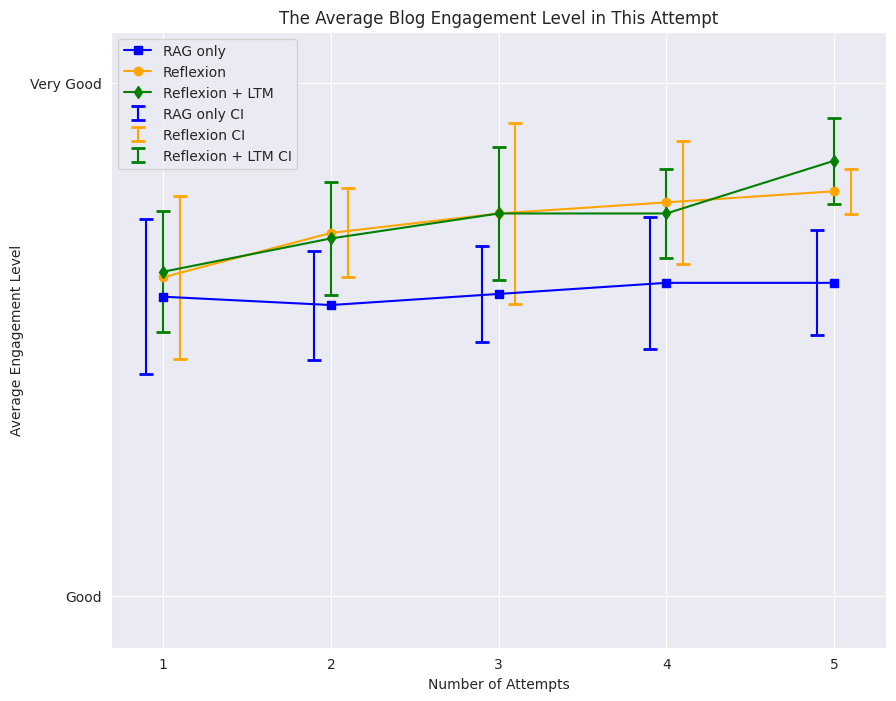

In [24]:
rag_exp = []
for i in range(1, EXPERIMENT_NUMBER + 1):
    exp_data = np.array(assessment_history["RAG only"][f"Experiment {i}"])
    rag_exp.append(np.mean(exp_data, axis=0))

reflexion_exp = []
for i in range(1, EXPERIMENT_NUMBER + 1):
    exp_data = np.array(assessment_history["Reflexion"][f"Experiment {i}"])
    reflexion_exp.append(np.mean(exp_data, axis=0))

ltm_exp = []
for i in range(1, EXPERIMENT_NUMBER + 1):
    exp_data = np.array(assessment_history["Reflexion + LTM"][f"Experiment {i}"])
    ltm_exp.append(np.mean(exp_data, axis=0))

plot(rag_exp, reflexion_exp, ltm_exp, "The Average Blog Engagement Level in This Attempt")

In [25]:
try:
    with open(GENERATOR_BEST_ASSESSMENTS_PATH, "r", encoding="utf-8") as file:
        best_assessment_history = json.load(file)
except Exception as e:
    print(f"{e}\n"
          f"Results not founded.")

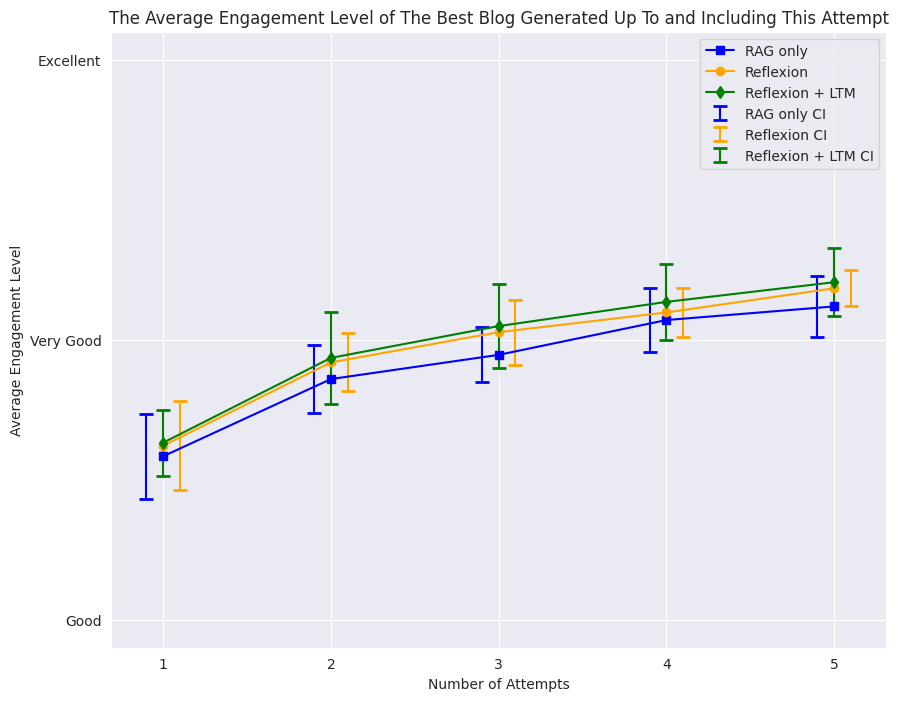

In [26]:
rag_exp_best = []
for i in range(1, EXPERIMENT_NUMBER + 1):
    exp_data = np.array(best_assessment_history["RAG only"][f"Experiment {i}"])
    rag_exp_best.append(np.mean(exp_data, axis=0))

reflexion_exp_best = []
for i in range(1, EXPERIMENT_NUMBER + 1):
    exp_data = np.array(best_assessment_history["Reflexion"][f"Experiment {i}"])
    reflexion_exp_best.append(np.mean(exp_data, axis=0))

ltm_exp_best = []
for i in range(1, EXPERIMENT_NUMBER + 1):
    exp_data = np.array(best_assessment_history["Reflexion + LTM"][f"Experiment {i}"])
    ltm_exp_best.append(np.mean(exp_data, axis=0))

plot(rag_exp_best, reflexion_exp_best, ltm_exp_best, "The Average Engagement Level of The Best Blog Generated Up To and Including This Attempt")